In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./dataset/mental_support_20250114_1830.csv")
df.head()

,title,selftext,timestamps,subreddit,link_flair_text
0,Gravity - talk it out,"Hey you, yeah you! Take a moment... to realis...",1708614000,MentalHealthSupport,Resources
1,Anger issues at just one person?,"I’ve always been a super chill person, and I’v...",1708614000,MentalHealthSupport,Question
2,Help Needed,"Hello, my name is Pamela. Not sure if this all...",1708614000,MentalHealthSupport,Resources
3,Need advice- Should/when should I tell my part...,"Hello, i'm a 24 y/o woman who's been dating a ...",1708614000,MentalHealthSupport,Question
4,Need advice about project for a Uni course,Hi Redditors! \n\nI have a situation I need ad...,1708614000,MentalHealthSupport,Question


In [3]:
# Initial length
print("Initial length:", len(df))

# Remove rows where selftext is NaN or [null]
df = df[~df['selftext'].isna() & 
        (df['selftext'] != '[null]') & 
        (df['selftext'].str.strip() != '')]
print("After removing empty/null selftext:", len(df))

# Remove duplicates in selftext
df = df.drop_duplicates(subset=['selftext'])
print("After removing duplicates:", len(df))

# Remove rows where flair is NaN or [null]
df = df[~df['link_flair_text'].isna() & 
        (df['link_flair_text'] != '[null]') & 
        (df['link_flair_text'].str.strip() != '')]
print("After removing empty/null flairs:", len(df))

# Optional: Reset index after all the filtering
df = df.reset_index(drop=True)

Initial length: 21777
After removing empty/null selftext: 17770
After removing duplicates: 17663
After removing empty/null flairs: 17642


In [4]:
df['text'] = df['title'] + ' : ' + df['selftext'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17642 entries, 0 to 17641
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            17642 non-null  object
 1   selftext         17642 non-null  object
 2   timestamps       17642 non-null  object
 3   subreddit        17642 non-null  object
 4   link_flair_text  17642 non-null  object
 5   text             17642 non-null  object
dtypes: object(6)
memory usage: 827.1+ KB


In [5]:
len(df["link_flair_text"].unique())

236

In [6]:
def map_flairs_to_categories(df):
    """
    Map flairs to their categories and add a new column to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'link_flair_text' column
        
    Returns:
        pd.DataFrame: DataFrame with new 'flair_category' column
    """
    
    # Define categories dictionary
    categories = {
        "Questions": [
            "Question", "Question/Discussion", "Question/Support", 
            "Question/Vent", "Question about OCD and ERP",
            "Mental health provider question", "Quick question",
            "Serious Question", "Question/Help", "MH Question",
            "Question:snoo_sad:", "Question / Need some advice",
            "Question and vent", "Question/Support :doge:",
            "Question/ asking for advice", "Question/advice"
        ],
        "Support Requests": [
            "Need Support", "I need help", "Help me",
            "Looking for a mental health buddy", "Need advice",
            "Support Group", "help please", "I need advice/support",
            "Needing Advice", "Help and need advice", "help",
            "advice wanted", "advice needed", "Support ",
            "I need advice/support - No complicated language please",
            "I need advice/support - No medicalising please",
            "help ", "advice", "advice?", "Asking for advice",
            # "Depression", "Anxiety", "ADD, Anxiety", "OCD",
            # "PTSD", "Bipolar", "Body Dysmorphia", "Mental Health",
            # "depression", "Mental illness", "anxiety", "borderline",
            # "depression/anxiety", "mental illness", "bipolar",
            # "Anxiety/Brain Fog", "Worsening Depression", "Depression",
            # "ocd bpd schizoaffective violent intrusive thoughts",
            # "Mental Awareness", "Diagnosis", "Self diagnosed",
            # "mental health", "depressed", "Mental Health"
        ],
        "Mental Health Conditions": [
            "Depression", "Anxiety", "ADD, Anxiety", "OCD",
            "PTSD", "Bipolar", "Body Dysmorphia", "Mental Health",
            "depression", "Mental illness", "anxiety", "borderline",
            "depression/anxiety", "mental illness", "bipolar",
            "Anxiety/Brain Fog", "Worsening Depression", "Depression",
            "ocd bpd schizoaffective violent intrusive thoughts",
            "Mental Awareness", "Diagnosis", "Self diagnosed",
            "mental health", "depressed", "Mental Health"
        ],
        "Content Types": [
            "Art", "Video", "Blog post", "Poetry", "Diary Entry",
            "News", "Meme", "Creative", "Youtube Video",
            "Music Suggestion", "Article Suggestion", "Blog post",
            "Reddit blog/vlog post", "External blog/vlog post",
            "Original content", "Original creative art/writing",
            "🎶Music Suggestion🎧", "🍿Movie Suggestion🎥",
            "📷 Feel-Good Photography 📸", "👨‍🎨Artwork👩‍🎨",
            "Dairy Entry", "song", "Fantasy", "diary"
        ],
        "Emotional Expression": [
            "Venting", "Rant", "Emotion", "Feelings Friday",
            "Off My Chest", "Vent - No advice please",
            "Emotional Roller Coaster Ride", "venting",
            "Vent", "confused emotions", "vent", 
            "Vent - Supportive replies only/no advice please",
            "Vent - support and advice welcome",
            "Vent - Supportive replies only please (advice still welcome)",
            "venting i guess", "vent/support", "rant/support needed",
            "Rant, I guess", "Rambling, sorry", "rant"
        ],
        "Resources": [
            "Resources", "Research", "Article Suggestion",
            "Resource Share", "Research Study", "Informative",
            "Research/Study", "Research/study (mod approved)",
            "Official research/study", "Research Study - Mod Approved",
            "Resource Share", "💻Article Suggestion📰",
            "Research/study", "Research", "science",
            "Helpful aricle", "Theories"
        ],
        "Community": [
            "Success Story", "Milestone", "Introduction",
            "Community Help", "Discussion", "Announcement",
            "40,000 members!", "Good News", "Uplifting",
            "Milestone", "Community Help", "Success Story",
            "Discussion Starter", "First post here",
            "Milestones and Celebrations!🎉✨🏝️",
            "Life Changing", "Good News / Happy",
            "Inspiration / Encouragement", "New Discord"
        ],
        "Content Warnings": [
            "Trigger warning ⚠️", "TRIGGER WARNING",
            "Content Warning: Suicidal Thoughts / Self Harm",
            "Content Warning: Sexual Assault", "Content Warning: Violence",
            "TW", "TRIGGER", "Trigger warning/advice",
            "May be trigerring ⚠️", "Trigger warning ⚠️",
            "Content Warning: Addiction / Substance Abuse",
            "Content Warning: Eating Disorders", "TRIGGER ",
            "Potential trigger warning", "NSFW"
        ],
        "Other": [
            "General", "Long", "LONG", "Long ", 
            "Identity", "Confidence", "Self Care",
            "Personal Experience", "Self Image",
            "Serious", "Opinions", "Other",
            "Activism", "Poll", "Mod Post",
            "Human Resource Issue", "Flair is fun!",
            "Crosspost", "Played", ":snoo_sad:",
            "🧠", "United States of America"
        ]
    }
    
    # Create a reverse mapping dictionary for exact matches
    flair_to_category = {}
    for category, flairs in categories.items():
        for flair in flairs:
            flair_to_category[flair.lower().strip()] = category
    
    def get_category(flair):
        """Helper function to get category for a single flair."""
        if pd.isna(flair):
            return "Uncategorized"
        
        # Try exact match first
        flair_lower = str(flair).lower().strip()
        if flair_lower in flair_to_category:
            return flair_to_category[flair_lower]
        
        # Try keyword matching if exact match fails
        keywords = {
            "Questions": ["question", "q&a"],
            "Support Requests": ["help", "support", "advice", "need", "depression", "anxiety", "mental health", "ocd", "bipolar"],
            "Mental Health Conditions": ["depression", "anxiety", "mental health", "ocd", "bipolar"],
            "Content Types": ["video", "art", "blog", "poetry", "diary"],
            "Emotional Expression": ["vent", "emotion", "feeling", "rant"],
            "Resources": ["resource", "research", "study", "article"],
            "Community": ["success", "milestone", "community", "announcement"],
            "Content Warnings": ["trigger", "warning", "tw", "nsfw"]
        }
        
        for category, category_keywords in keywords.items():
            if any(keyword in flair_lower for keyword in category_keywords):
                return category
                
        return "Other"
    
    # Add new column with categories
    df_copy = df.copy()
    df_copy['flair_category'] = df_copy['link_flair_text'].apply(get_category)
    
    return df_copy

In [7]:
df = map_flairs_to_categories(df)

# View distribution of categories
print("\nFlair Category Distribution:")
print(df['flair_category'].value_counts())

# View some examples
print("\nExample Mappings:")
print(df[['link_flair_text', 'flair_category']].sample(10))


Flair Category Distribution:
Support Requests            8102
Emotional Expression        2726
Questions                   2505
Other                       1719
Resources                    911
Community                    887
Content Warnings             570
Content Types                201
Mental Health Conditions      21
Name: flair_category, dtype: int64

Example Mappings:
             link_flair_text        flair_category
13819  I need advice/support      Support Requests
5043            Need Support      Support Requests
11125             Discussion             Community
3009            Need Support      Support Requests
9764   I need advice/support      Support Requests
4851                 Venting  Emotional Expression
9394   I need advice/support      Support Requests
10669  I need advice/support      Support Requests
8518              Discussion             Community
1138                 Venting  Emotional Expression



Flair Category Distribution:
Support Requests            8102
Emotional Expression        2726
Questions                   2505
Other                       1719
Resources                    911
Community                    887
Content Warnings             570
Content Types                201
Mental Health Conditions      21
Name: flair_category, dtype: int64


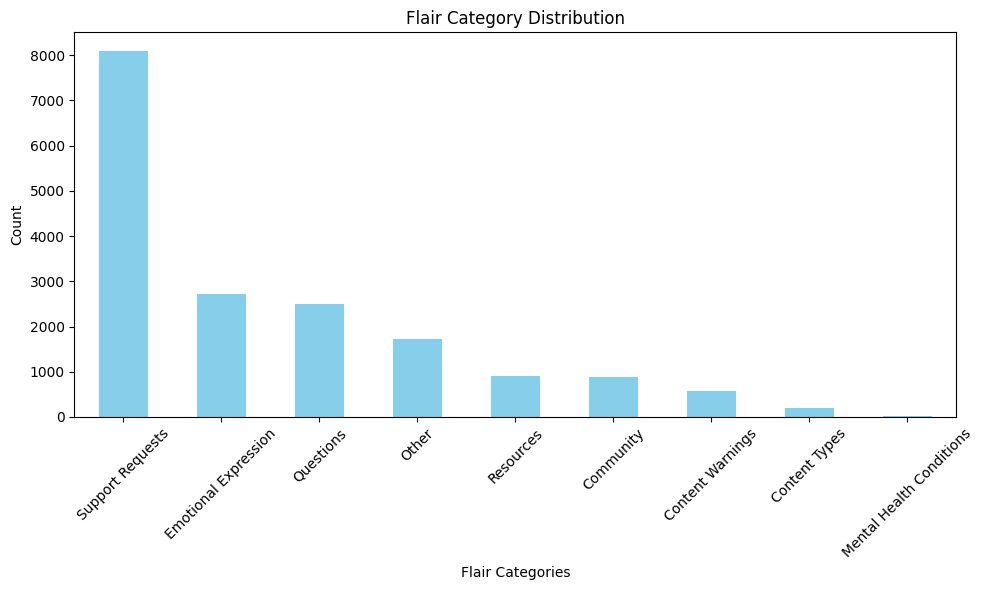

In [8]:
import matplotlib.pyplot as plt

# View distribution of categories
print("\nFlair Category Distribution:")
print(df['flair_category'].value_counts())

# Plotting the flair category distribution
plt.figure(figsize=(10, 6))
df['flair_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Flair Category Distribution')
plt.xlabel('Flair Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Text Processing

In [9]:
!pip install -q nltk

In [10]:
import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [11]:
def process_text(text):
    """Combined text preprocessing function."""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase and remove special patterns
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Fixed phone number pattern - escaped hyphen and parentheses
    text = re.sub(r'\+?[0-9][\d\s\-\(\)]{8,}[0-9]', '', text)  # Changed to \d and escaped special chars
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization and cleaning
    words = text.split()
    cleaned_words = []
    
    # Domain-specific stopwords
    domain_stopwords = {
        'feel', 'feeling', 'felt', 'think', 'thinking', 'thought',
        'want', 'wanted', 'wanting', 'need', 'needed', 'needing',
        'like', 'liked', 'likely', 'help', 'helped', 'helping'
    }
    all_stopwords = stop_words.union(domain_stopwords)
    
    # Process each word
    for word in words:
        if word not in all_stopwords:
            pos_tag = nltk.pos_tag([word])[0][1][0].upper()
            pos = {'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}.get(pos_tag, wordnet.NOUN)
            lemmatized = lemmatizer.lemmatize(word, pos=pos)
            cleaned_words.append(lemmatized)
    
    return ' '.join(cleaned_words)


In [12]:
# URL removal
# Email removal
# Phone number removal
# HTML tag removal
# Special character removal
# Lemmatization with proper POS tagging
# Custom domain-specific stopwords removal

In [13]:
# Apply to your dataframe
df['cleaned_text'] = df['text'].apply(process_text)

In [14]:
df.head()

,title,selftext,timestamps,subreddit,link_flair_text,text,flair_category,cleaned_text
0,Gravity - talk it out,"Hey you, yeah you! Take a moment... to realis...",1708614000,MentalHealthSupport,Resources,"Gravity - talk it out : Hey you, yeah you! Ta...",Resources,gravity talk hey yeah take moment realise huma...
1,Anger issues at just one person?,"I’ve always been a super chill person, and I’v...",1708614000,MentalHealthSupport,Question,Anger issues at just one person? : I’ve always...,Questions,anger issue one person ive always super chill ...
2,Help Needed,"Hello, my name is Pamela. Not sure if this all...",1708614000,MentalHealthSupport,Resources,"Help Needed : Hello, my name is Pamela. Not su...",Resources,hello name pamela sure allow worth shot strugg...
3,Need advice- Should/when should I tell my part...,"Hello, i'm a 24 y/o woman who's been dating a ...",1708614000,MentalHealthSupport,Question,Need advice- Should/when should I tell my part...,Questions,advice shouldwhen tell partner past mental hea...
4,Need advice about project for a Uni course,Hi Redditors! \n\nI have a situation I need ad...,1708614000,MentalHealthSupport,Question,Need advice about project for a Uni course : H...,Questions,advice project uni course hi redditors situati...


In [15]:
len(df)

17642

In [16]:
# ... existing code ...
df.to_csv("./dataset/mental_support_subreddit.csv", index=False)